### Use `RGBD` camera

In [1]:
import mujoco,cv2,pyvista
import numpy as np
import matplotlib.pyplot as plt
# from pyntcloud import PyntCloud
import sys
sys.path.append('../../')
from utils.mujoco_parser import MuJoCoParserClass
from utils.util import sample_xyzs,rpy2r,r2rpy,compute_view_params,get_interp_const_vel_traj
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

MuJoCo version:[2.3.7]


### Parse `UR5e` with `RG2` gripper

In [2]:
xml_path = '../../asset/ur5e/scene_ur5e_rg2_d435i_obj.xml'
env = MuJoCoParserClass(name='UR5e with RG2 gripper',rel_xml_path=xml_path,VERBOSE=True)
obj_names = [body_name for body_name in env.body_names
             if body_name is not None and (body_name.startswith("obj_"))]
n_obj = len(obj_names)
# Place objects
xyzs = sample_xyzs(n_sample=n_obj,
                   x_range=[0.75, 1.25],y_range=[-0.38,0.38],z_range=[0.81,0.81],min_dist=0.2)
colors = np.array([plt.cm.gist_rainbow(x) for x in np.linspace(0,1,n_obj)])
for obj_idx,obj_name in enumerate(obj_names):
    jntadr = env.model.body(obj_name).jntadr[0]
    env.model.joint(jntadr).qpos0[:3] = xyzs[obj_idx,:]
    geomadr = env.model.body(obj_name).geomadr[0]
    # env.model.geom(geomadr).rgba = colors[obj_idx] # color

# Move tables and robot base
env.model.body('base_table').pos = np.array([0,0,0])
env.model.body('front_object_table').pos = np.array([1.05,0,0])
env.model.body('side_object_table').pos = np.array([0,-0.85,0])
env.model.body('base').pos = np.array([0.18,0,0.8])

print ("Ready.")

dt:[0.0020] HZ:[500]
n_dof (=nv):[60]
n_geom:[61]
geom_names:['floor', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
n_body:[30]
body_names:['world', 'base', 'shoulder_link', 'upper_arm_link', 'forearm_link', 'wrist_1_link', 'wrist_2_link', 'wrist_3_link', 'tcp_link', 'camera_mount', 'd435i', 'rg2_gripper_base_link', 'camera_center', 'rg2_gripper_finger1_finger_link', 'rg2_gripper_finger1_inner_knuckle_link', 'rg2_gripper_finger1_finger_tip_link', 'rg2_gripper_finger2_finger_link', 'rg2_gripper_finger2_inner_knuckle_link', 'rg2_gripper_finger2_finger_tip_link', 'front_object_table', 'side_object_table', 'base_table', 'obj_cylinder_01', 'obj_cylinder_02', 'obj_cylinder_03', 'obj

### Render

In [3]:
# Init viewer
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=66.08,distance=3.0,elevation=-50,lookat=[0.4,0.18,0.71],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=True,jointlength=0.25,jointwidth=0.05,jointrgba=[0.2,0.6,0.8,0.6])
# Base pose
body_name = 'tcp_link'
p_base = env.get_p_body(body_name='base')

# Straight pose
DO_RENDER_IK = True
p_trgt = p_base + np.array([0.6,0.3,0.5])
R_trgt = rpy2r(np.radians([0,0,0]))@rpy2r(np.radians([-180,0,90]))
rev_joint_idxs = [0,1,2,3,4,5]
q_prepose_00 = env.solve_ik(
    body_name=body_name,p_trgt=p_trgt,R_trgt=R_trgt,IK_P=True,IK_R=True,
    q_init=np.radians([0,-90,0,0,0,0]),rev_joint_idxs=rev_joint_idxs,
    RESET=False,DO_RENDER=DO_RENDER_IK,render_every=1,th=1*np.pi/180.0,err_th=1e-2)

# 30 deg down pose
p_trgt = p_base + np.array([0.2,-0.1,0.3])
R_trgt = rpy2r(np.radians([0,90,0]))@rpy2r(np.radians([-180,0,90]))
rev_joint_idxs = [0,1,2,3,4,5]
q_prepose_30 = env.solve_ik(
    body_name=body_name,p_trgt=p_trgt,R_trgt=R_trgt,IK_P=True,IK_R=True,
    q_init=q_prepose_00,rev_joint_idxs=rev_joint_idxs,
    RESET=False,DO_RENDER=DO_RENDER_IK,render_every=1,th=1*np.pi/180.0,err_th=1e-4)

# 60 deg down pose
p_trgt = p_base + np.array([0.4,0.0,0.5])
R_trgt = rpy2r(np.radians([0,60,0]))@rpy2r(np.radians([-180,0,90]))
rev_joint_idxs = [0,1,2,3,4,5]
q_prepose_60 = env.solve_ik(
    body_name=body_name,p_trgt=p_trgt,R_trgt=R_trgt,IK_P=True,IK_R=True,
    q_init=q_prepose_30,rev_joint_idxs=rev_joint_idxs,
    RESET=False,DO_RENDER=DO_RENDER_IK,render_every=1,th=1*np.pi/180.0,err_th=1e-4)

env.close_viewer()
print ("IK done.")

# Get joint trajectory
times,q_traj = get_interp_const_vel_traj(
    np.vstack((q_prepose_60,q_prepose_30,q_prepose_30,q_prepose_60)),
    vel=np.radians(30),HZ=env.HZ)
print ("q_traj's L:[%d] time_max:[%.2f]sec"%(times.shape[0],times[-1]))


IK done.
q_traj's L:[1390] time_max:[2.78]sec


In [4]:
# Init viewer
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=66.08,distance=3.0,elevation=-50,lookat=[0.4,0.18,0.71],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=True,jointlength=0.25,jointwidth=0.05,jointrgba=[0.2,0.6,0.8,0.6])

pcd_tick = 0

# Reset
env.reset()
env.forward(q=q_traj[0,:],joint_idxs=[0,1,2,3,4,5])
tick,max_sec = 0,100
while env.get_sim_time() <= max_sec:
    # Step
    q = np.append(q_traj[tick,:],1.0) # open gripper
    env.step(ctrl=q,ctrl_idxs=[0,1,2,3,4,5,6])
    tick = min(tick + 1,q_traj.shape[0]-1)
    if not env.is_viewer_alive(): break
        
    # Render
    if env.loop_every(HZ=20):
        # Compute some poses
        p_tcp,R_tcp = env.get_pR_body(body_name='tcp_link')
        p_cam,R_cam = env.get_pR_body(body_name='camera_center')
        p_base,R_base = env.get_pR_body(body_name='base')
        # Get PCD from a specific view
        p_ego  = p_cam
        p_trgt = p_cam + R_cam[:,2]
        rgb_img,depth_img,pcd,xyz_img = env.get_egocentric_rgb_depth_pcd(
            p_ego=p_ego,p_trgt=p_trgt,rsz_rate=20,fovy=45,BACKUP_AND_RESTORE_VIEW=True)

        # Save PCD
        pcd_tick += 1
        # for p in pcd: env.plot_sphere(p=p,r=0.005,rgba=[0.95,0.05,0.05,1])
        env.render(render_every=1)
        
# Close viewer
env.close_viewer()
print ("Done. Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()))

Pressed ESC
Quitting.
Done. Tick:[1802] Time:[3.60]sec


### Check current egocentric view

rgb_img:(800, 1200, 3), depth_img:(800, 1200), pcd:(9600, 3), xyz_img:(80, 120, 3)


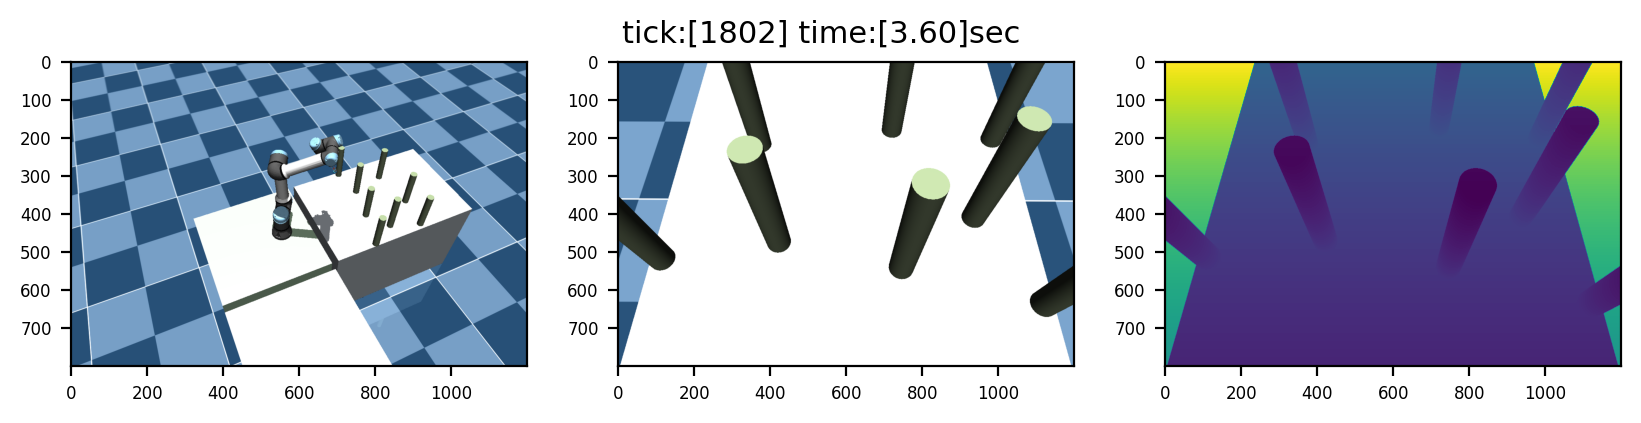

In [5]:
# Init viewer
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=66.08,distance=3.0,elevation=-50,lookat=[0.4,0.18,0.71],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=True,jointlength=0.25,jointwidth=0.05,jointrgba=[0.2,0.6,0.8,0.6])

# Get egocentric view
rgb_img,depth_img,pcd,xyz_img = env.get_egocentric_rgb_depth_pcd(
    p_ego=p_ego,p_trgt=p_trgt,rsz_rate=10,fovy=45,BACKUP_AND_RESTORE_VIEW=True)
# Print
print ("rgb_img:%s, depth_img:%s, pcd:%s, xyz_img:%s"%
       (rgb_img.shape,depth_img.shape,pcd.shape,xyz_img.shape))
# Plot
fig,axs = plt.subplots(1,3,figsize=(10,2))
scene_img = env.grab_image()
axs[0].imshow(scene_img); axs[1].imshow(rgb_img); axs[2].imshow(depth_img)
fig.suptitle('tick:[%d] time:[%.2f]sec'%(env.tick,env.get_sim_time()),fontsize=11)
plt.subplots_adjust(wspace=0.2); plt.show()
# Close viewer
env.close_viewer()

# Save Data
plt.imsave('./results/rgb_img.png',rgb_img)
plt.imsave('./results/depth_img.png',depth_img)
np.save('./results/pcd.npy',pcd)

## Load `OWL-ViT+SAM` modules

In [6]:
from foundations.fastsam import FastSAM, FastSAMPrompt
from foundations.utils.tools import convert_box_xywh_to_xyxy
import ast
import torch
from PIL import Image

from transformers import OwlViTProcessor, OwlViTForObjectDetection

In [7]:
FAST_SAM_PTH = "../../foundations/weights/FastSAM.pt"
point_prompt = "[[0,0]]"
box_prompt = "[[0,0,0,0]]"
point_label = "[0]"

model = FastSAM(FAST_SAM_PTH)
point_prompt = ast.literal_eval(point_prompt)
box_prompt = convert_box_xywh_to_xyxy(ast.literal_eval(box_prompt))
point_label = ast.literal_eval(point_label)
input = rgb_img
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")
print("Done.")


Device: cuda:0
Done.


In [8]:
everything_results = model(
    input,
    device=device,
    retina_masks=True,
    imgsz=1024,
    conf=0.4,   # object confidence threshold
    iou=0.9    
    )
bboxes = None
points = None
point_label = None
prompt_process = FastSAMPrompt(input, everything_results, device=device)



0: 704x1024 30 objects, 178.6ms
Speed: 2.9ms preprocess, 178.6ms inference, 7.1ms postprocess per image at shape (1, 3, 1024, 1024)


In [9]:
annotations = prompt_process.everything_prompt()

result = prompt_process.plot_to_result(
    annotations, 
    bboxes, 
    points, 
    point_label, 
    mask_random_color=True,
    better_quality=True, 
    retina=False, 
    withContours=False,
)

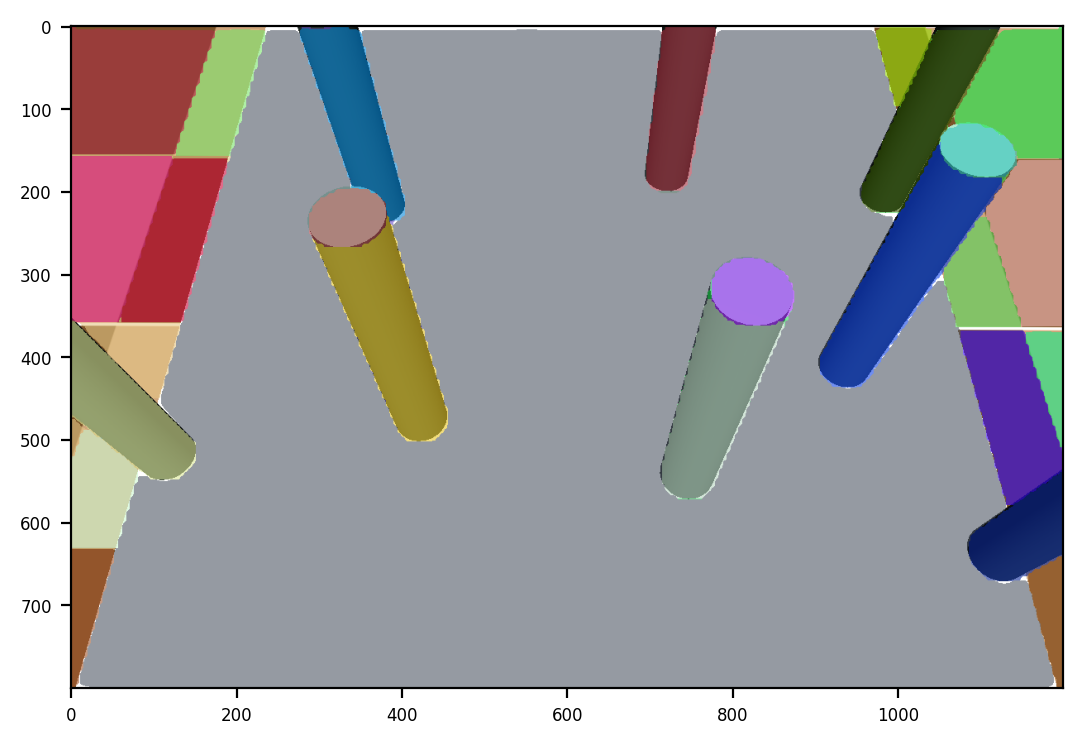

In [10]:
result = result[:, :, ::-1]
plt.imshow(result)
plt.show()

In [11]:
def load_owlvit(checkpoint_path="owlvit-large-patch14", device='cpu'):
    """
    Return: model, processor (for text inputs)
    """
    processor = OwlViTProcessor.from_pretrained(f"google/{checkpoint_path}")
    model = OwlViTForObjectDetection.from_pretrained(f"google/{checkpoint_path}")
    model.to(device)
    model.eval()
    
    return model, processor

In [12]:
text_prompt = "all of cylinders"
output_dir = "./results/"
box_threshold = 0.0
get_topk = True

if get_topk:
    box_threshold = 0.0

# load image & texts
image = Image.open("./results/rgb_img.png").convert("RGB")
# texts = [text_prompt.split(",")]
texts = text_prompt

# load OWL-ViT model
model, processor = load_owlvit(checkpoint_path="owlvit-base-patch32", device=device)

# run object detection model
with torch.no_grad():
    inputs = processor(text=texts, images=image, return_tensors="pt").to(device)
    outputs = model(**inputs)

In [13]:
# Target image sizes (height, width) to rescale box predictions [batch_size, 2]
target_sizes = torch.Tensor([image.size[::-1]])
# Convert outputs (bounding boxes and class logits) to COCO API
results = processor.post_process_object_detection(outputs=outputs, threshold=box_threshold, target_sizes=target_sizes.to(device))
scores = torch.sigmoid(outputs.logits)
topk_scores, topk_idxs = torch.topk(scores, k=1, dim=1)

In [14]:
import copy
import gc
from PIL import Image, ImageDraw, ImageFont
import os

i = 0  # Retrieve predictions for the first image for the corresponding text queries
text = texts[i]
if get_topk:    
    topk_idxs = topk_idxs.squeeze(1).tolist()
    topk_boxes = results[i]['boxes'][topk_idxs]
    topk_scores = topk_scores.view(len(text), -1)
    topk_labels = results[i]["labels"][topk_idxs]
    boxes, scores, labels = topk_boxes, topk_scores, topk_labels
else:
    boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]


# Print detected objects and rescaled box coordinates
for box, score, label in zip(boxes, scores, labels):
    box = [round(i, 2) for i in box.tolist()]
    print(f"Detected {text[label]} with confidence {round(score.item(), 3)} at location {box}")

boxes = boxes.cpu().detach().numpy()
normalized_boxes = copy.deepcopy(boxes)

# # visualize pred
size = image.size
pred_dict = {
    "boxes": normalized_boxes,
    "size": [size[1], size[0]], # H, W
    "labels": [text[idx] for idx in labels]
}

# release the OWL-ViT
model.cpu()
del model
gc.collect()
torch.cuda.empty_cache()


Detected a with confidence 0.006 at location [135.51, -5.22, 1183.45, 683.55]


In [15]:
device

'cuda:0'

In [16]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  

def plot_boxes_to_image(image_pil, tgt):
    H, W = tgt["size"]
    boxes = tgt["boxes"]
    labels = tgt["labels"]
    assert len(boxes) == len(labels), "boxes and labels must have same length"

    draw = ImageDraw.Draw(image_pil)
    mask = Image.new("L", image_pil.size, 0)
    mask_draw = ImageDraw.Draw(mask)

    # draw boxes and masks
    for box, label in zip(boxes, labels):
        # random color
        color = tuple(np.random.randint(0, 255, size=3).tolist())
        # draw
        x0, y0, x1, y1 = box
        x0, y0, x1, y1 = int(x0), int(y0), int(x1), int(y1)

        draw.rectangle([x0, y0, x1, y1], outline=color, width=6)
        draw.text((x0, y0), str(label), fill=color)

        font = ImageFont.load_default()
        if hasattr(font, "getbbox"):
            bbox = draw.textbbox((x0, y0), str(label), font)
        else:
            w, h = draw.textsize(str(label), font)
            bbox = (x0, y0, w + x0, y0 + h)
        # bbox = draw.textbbox((x0, y0), str(label))
        draw.rectangle(bbox, fill=color)
        draw.text((x0, y0), str(label), fill="white")

        mask_draw.rectangle([x0, y0, x1, y1], fill=255, width=6)

    return image_pil, mask


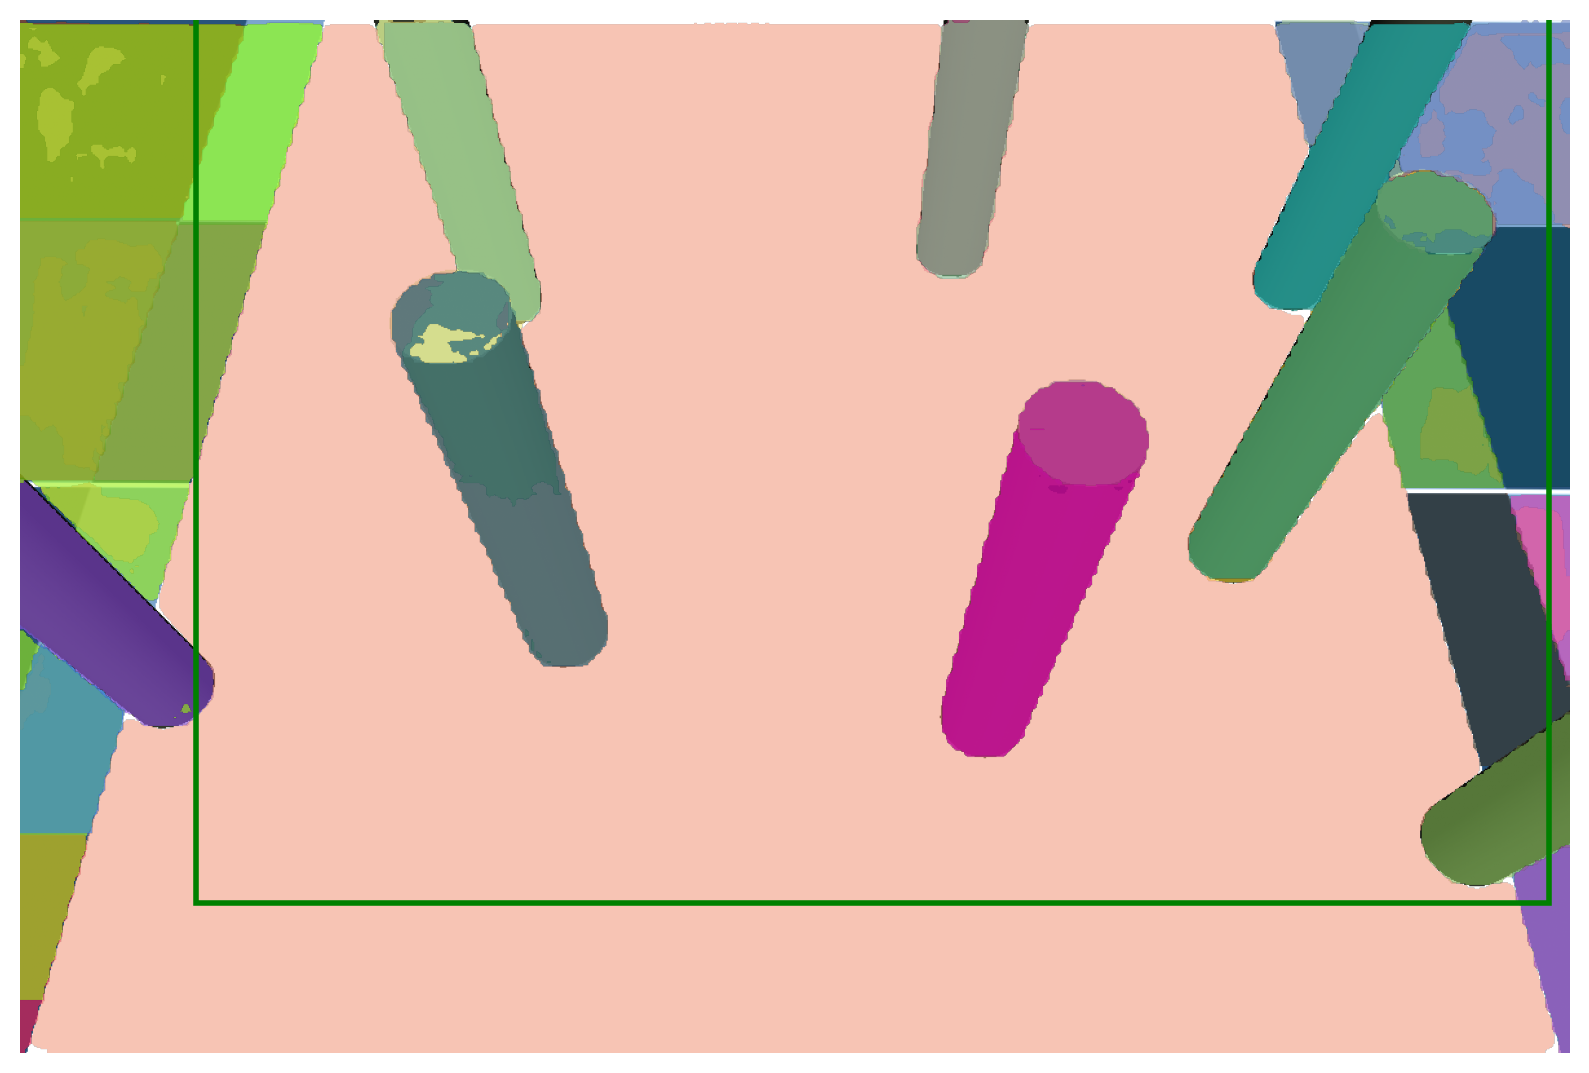

In [17]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in annotations:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
for box in boxes:
    show_box(box, plt.gca())
plt.axis('off')
plt.savefig(f"./{output_dir}/owlvit_segment_anything_output.jpg")



In [20]:
# grounded results
image_pil = Image.open("./results/rgb_img.png").convert("RGB")
image_with_box = plot_boxes_to_image(image_pil, pred_dict)[0]
image_with_box.save(os.path.join(f"./{output_dir}/owlvit_box.jpg"))
